In [2]:
import skimage.io
import numpy as np

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [135]:
#!/usr/bin/env python
# coding: utf-8

# In[71]:


import numpy as np
from skimage import transform, io, color
import matplotlib.pyplot as plt
from time import time


# In[30]:
def get_image_energy(image):
    """
    image -- grayscale image
    """
    dx_map = np.roll(image, 1, axis=0) - np.roll(image, -1, axis=0)
    dy_map = np.roll(image, 1, axis=1) - np.roll(image, -1, axis=1)
    dx_map[0, :], dy_map[:, 0] = image[1, :] - image[0, :], image[:, 1] - image[:, 0]
    dx_map[-1, :], dy_map[:, -1] = image[-1, :] - image[-2, :], image[:, -1] - image[:, -2]
    return np.sqrt(dx_map ** 2 + dy_map ** 2)

# In[60]:
def create_way_matrix(image_energy, max_energy, mask=None):
    h, w = image_energy.shape[:2]
    way_matrix = image_energy.copy()
    if mask is not None:
        way_matrix += max_energy * mask
    for i in range(1, h):
        way_matrix[i, 0] += np.min(way_matrix[i - 1, :2])
        way_matrix[i, -1] += np.min(way_matrix[i - 1, -2:])
        way_matrix[i, 1:-1] += np.min(
            np.vstack(
                (way_matrix[i - 1], np.roll(way_matrix[i - 1], -1), np.roll(way_matrix[i - 1], -2))
            )[:, :-2], 
            axis=0
        )
    return way_matrix

# In[66]:
def find_seam(way_matrix):
    """
    @return: seam_mask
    """
    seam_mask = np.zeros_like(way_matrix, dtype=np.int8)
    h, w = way_matrix.shape[:2]
    j = np.argmin(way_matrix[h - 1])
    seam_mask[h - 1, j] = 1
    for i in range(h - 1)[::-1]:
        j = max(0, j - 1) + np.argmin(way_matrix[i, max(0, j - 1):min(j + 2, w )])
        seam_mask[i, j] = 1
    return seam_mask


# In[109]:
def seam_preprocessing(image, mask, mode, gs_const = np.array([0.299, 0.587, 0.114])):
    image_gray = np.dot(image, gs_const)
    if mode in ["vertical shrink", "vertical expand"]:
        image_gray = image_gray.T
        if mask is not None:
            mask = mask.T
    return image_gray, mask

# In[118]:
def seam_postprocessing(seam_mask, mode):
    if mode in ["vertical shrink", "vertical expand"]:
        seam_mask = seam_mask.T
    return seam_mask 

# In[119]:
def seam_carve(image, mode, mask=None):
    """
    @return: resp_image - updated image
             upd_mask - updated mask
             seam_mask - маска шва  (1 — пиксели, которые принадлежат шву; 0 — пиксели, которые не принадлежат шву)
    """
    
#     start = time()
    max_energy = image.shape[0] * image.shape[1] * 256
    image_gray, mask = seam_preprocessing(image, mask, mode)
#     print("seam_preprocessing {}".format(time() - start))
#     start = time()
    image_energy = get_image_energy(image_gray)
#     print("get_image_energy {}".format(time() - start))
#     start = time()
    way_matrix = create_way_matrix(image_energy, max_energy, mask)
#     print("create_way_matrix {}".format(time() - start))
#     start = time()
    seam_mask = find_seam(way_matrix)
#     print("find_seam {}".format(time() - start))
#     start = time()
    seam_mask = seam_postprocessing(seam_mask, mode)
#     print("seam_postprocessing {}".format(time() - start))
    return image, mask, seam_mask



In [47]:
image = skimage.io.imread('public_data/03_input/img.png')
mask = skimage.io.imread('public_data/03_input/mask.png')

In [392]:
image = image / 255.

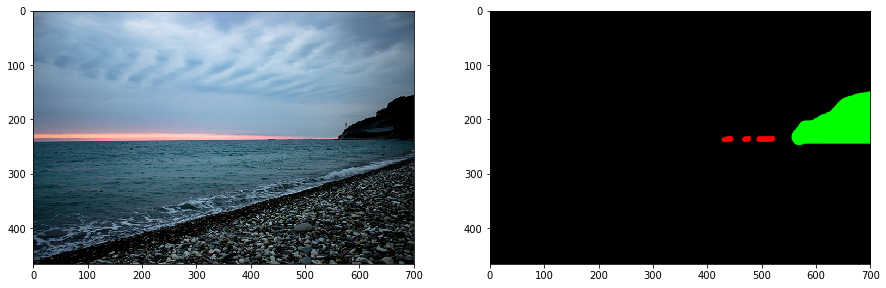

In [48]:
plt.figure(figsize=[15, 12])
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(mask)

In [49]:
def get_intensity(img):
    weights = np.array([0.299, 0.587, 0.114])
    return np.dot(img, weights)

In [50]:
def get_intensity_with_mask_old(intensities, mask):
    intensity_with_mask = intensities.copy()

    h, w = intensities.shape
    for i in range(h):
        mask_red = np.nonzero(mask[i, :, 0])
        mask_green = np.nonzero(mask[i, :, 1])
        intensity_with_mask[i, mask_red] -= h * w * 256
        intensity_with_mask[i, mask_green] += h * w * 256
    
    return intensity_with_mask

In [51]:
def get_intensity_with_mask(intensities, mask):
    intensity_with_mask = intensities.copy()

    h, w = intensities.shape
    intensity_with_mask -= (mask < 0) * h * w * 256
    intensity_with_mask += (mask > 0) * h * w * 256
    
    return intensity_with_mask

In [52]:
def get_intensities_sum(intensity_with_mask):
    intensity_sum = intensity_with_mask.copy()
    
    h, w = intensity_with_mask.shape
    for i in range(1, h):
        for j in range(0, w):
            add = intensity_sum[i - 1, j]
            if j > 0:
                add = np.min([add, intensity_sum[i - 1, j - 1]])
            if j < w - 1:
                add = np.min([add, intensity_sum[i - 1, j + 1]])
            intensity_sum[i, j] += add
    
    return intensity_sum

In [53]:
def get_grad_intensity(intensity):
    h, w = intensity.shape
    I_x = np.zeros(intensity.shape)
    I_y = np.zeros(intensity.shape)
    for i in range(h):
        for j in range(w):
            if i in range(1, h - 1):
                I_x[i, j] = intensity[i + 1, j] - intensity[i - 1, j]
                if i == 100 and j == 100:
                    print(I_x[i, j])
            elif i == 0:
                I_x[i, j] = intensity[1, j] - intensity[i, j]
            elif i == h - 1:
                I_x[i, j] = intensity[i, j] - intensity[i - 1, j]
            
            if j in range(1, w - 1):
                I_y[i, j] = intensity[i, j + 1] - intensity[i, j + 1]
            elif j == 0:
                I_y[i, j] = intensity[i, j + 1] - intensity[i, j]
            elif j == w - 1:
                I_y[i, j] = intensity[i, j] - intensity[i, j - 1]
    grads = np.linalg.norm(np.array([I_x, I_y]), axis=0)
    return grads, I_x, I_y

In [54]:
def get_min_seam(intensity_sum, intensity):
    h, w = intensity.shape
    seam = [np.argmin(intensity_sum[h - 1])]
    for i in range(h - 2, -1, -1):
        last_seam = seam[-1]
        diff = intensity_sum[i + 1, last_seam] - intensity[i + 1, last_seam]
        if last_seam > 0 and intensity_sum[i, last_seam - 1] == diff:
            seam.append(last_seam - 1)
        elif last_seam < w - 1 and intensity_sum[i, last_seam + 1] == diff:
            seam.append(last_seam + 1)
        else:
            seam.append(last_seam)
        #print(i, len(seam), end=' ')
    return seam[::-1]

In [55]:
image_with_seam = image.copy()

In [157]:
def get_intensities_sum_(grad_intensity):
    intensity_sum = grad_intensity.copy()
    h, w = grad_intensity.shape
    for i in range(1, h):
        add = np.zeros(w)
        add[0] = np.min(intensity_sum[i - 1, :2])
        add[-1] = np.min(intensity_sum[i - 1, -2:])
        last_block = np.array([intensity_sum[i - 1, 1:-1], intensity_sum[i - 1, 2:], intensity_sum[i - 1, :-2]])
        add[1:-1] = np.min(last_block,  axis=0)
        intensity_sum[i] += add

    return intensity_sum

In [159]:
sums = get_intensities_sum_(grad_intensity)

In [160]:
np.allclose(sums, way_matrix)

True

In [147]:
intensity = get_intensity(image)# get_intensity(image)
grad_intensity = get_image_energy(intensity)

#grad_copy = grad_intensity.copy()

intensity_sum = get_intensities_sum(grad_intensity)
min_seam = get_min_seam(intensity_sum, grad_intensity)

CPU times: user 3.98 s, sys: 21.7 ms, total: 4 s
Wall time: 3.99 s


In [148]:
%%time
intensity_sum = get_intensities_sum(grad_intensity)

CPU times: user 4.12 s, sys: 39.3 ms, total: 4.16 s
Wall time: 4.14 s


In [141]:
np.allclose(grad_intensity, image_energy)

True

In [144]:
np.allclose(way_matrix, intensity_sum)

True

In [133]:
image_gray, mask = seam_preprocessing(image, mask, mode)
image_energy = get_image_energy(image_gray)

#intensity, _ = seam_preprocessing(image, mask, mode)
#grad_intensity = get_image_energy(intensity)

In [146]:
%%time

mode = 'horizontal'
mask = None
max_energy = image.shape[0] * image.shape[1] * 256
image_gray, mask = seam_preprocessing(image, mask, mode)
#     print("seam_preprocessing {}".format(time() - start))
#     start = time()
image_energy = get_image_energy(image_gray)
#     print("get_image_energy {}".format(time() - start))
#     start = time()
way_matrix = create_way_matrix(image_energy, max_energy, mask)
#     print("create_way_matrix {}".format(time() - start))
#     start = time()
seam_mask = find_seam(way_matrix)
#     print("find_seam {}".format(time() - start))
#     start = time()
seam_mask = seam_postprocessing(seam_mask, mode)

CPU times: user 54.7 ms, sys: 5.1 ms, total: 59.8 ms
Wall time: 58.4 ms


In [72]:
seam_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [30]:
my_intensity = get_intensity(image)
my_intensity

array([[1.07766e+02, 1.11364e+02, 1.12364e+02, ..., 7.77560e+01,
        7.87560e+01, 7.77560e+01],
       [1.09076e+02, 1.12076e+02, 1.13777e+02, ..., 7.77560e+01,
        7.87560e+01, 7.67560e+01],
       [1.14272e+02, 1.14870e+02, 1.16973e+02, ..., 7.87560e+01,
        7.87560e+01, 7.67560e+01],
       ...,
       [7.47300e+00, 1.88600e+00, 1.48400e+00, ..., 3.40200e+00,
        2.63000e+00, 4.56000e-01],
       [0.00000e+00, 1.00000e+00, 4.13000e-01, ..., 2.28000e-01,
        1.14000e-01, 1.14000e-01],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 2.28000e-01,
        2.28000e-01, 1.22800e+00]])

In [33]:
grad_intensity

array([[ 3.82906046,  0.712     ,  1.413     , ...,  0.        ,
         0.        ,  1.41421356],
       [ 7.16435873,  3.506     ,  4.609     , ...,  1.        ,
         0.        ,  2.23606798],
       [ 9.70943278,  6.805     ,  7.104     , ...,  1.        ,
         2.        ,  3.60555128],
       ...,
       [16.05263125,  0.761     ,  1.359     , ...,  8.163     ,
         8.434     ,  5.52104166],
       [ 6.54978847,  1.886     ,  1.484     , ...,  3.174     ,
         2.402     ,  0.772     ],
       [ 1.41421356,  1.        ,  0.413     , ...,  0.        ,
         0.114     ,  1.49699566]])

In [32]:
image_energy

array([[3.82906046e+00, 4.65280002e+00, 2.69851255e+00, ...,
        2.00000000e+00, 0.00000000e+00, 1.41421356e+00],
       [1.09934192e+01, 8.56293384e+00, 7.51924383e+00, ...,
        1.00000000e+00, 1.00000000e+00, 2.23606798e+00],
       [1.82723666e+01, 1.48406799e+01, 1.36032107e+01, ...,
        2.41421356e+00, 3.82842712e+00, 4.60555128e+00],
       ...,
       [2.42879652e+03, 2.40401302e+03, 2.39814014e+03, ...,
        3.34733703e+03, 3.34951377e+03, 3.34674906e+03],
       [2.41056281e+03, 2.40007083e+03, 2.39992963e+03, ...,
        3.34788012e+03, 3.34915377e+03, 3.34752106e+03],
       [2.40148505e+03, 2.40134384e+03, 2.40034263e+03, ...,
        3.34788012e+03, 3.34852754e+03, 3.34901806e+03]])

In [65]:
for index, i in enumerate(min_seam):
    image_with_seam[index, i, 0] = 255
    image_with_seam[index, xs[index], 1] = 255

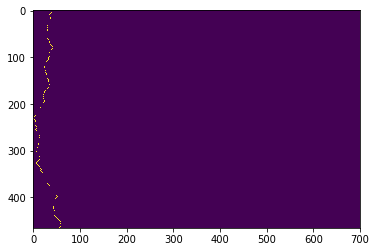

In [37]:
plt.imshow(seam)

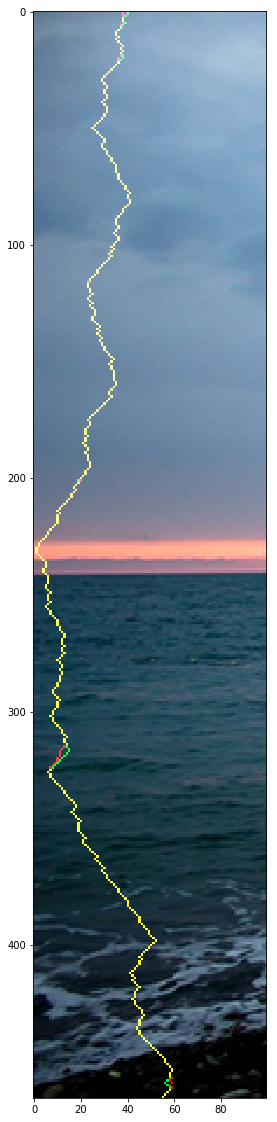

In [69]:
plt.figure(figsize=(10, 20))
plt.imshow(image_with_seam[:, :100])

In [74]:
my_mask = get_seam_mask(min_seam, image.shape[:2])

In [75]:
my_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
seam_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [107]:
X = np.array([my_mask, seam_mask, np.zeros(image.shape[:2])]).transpose((1, 2, 0))
X_ = np.array([my_mask, seam_mask, get_seam_mask(xs, image.shape[:2])]).transpose((1, 2, 0))

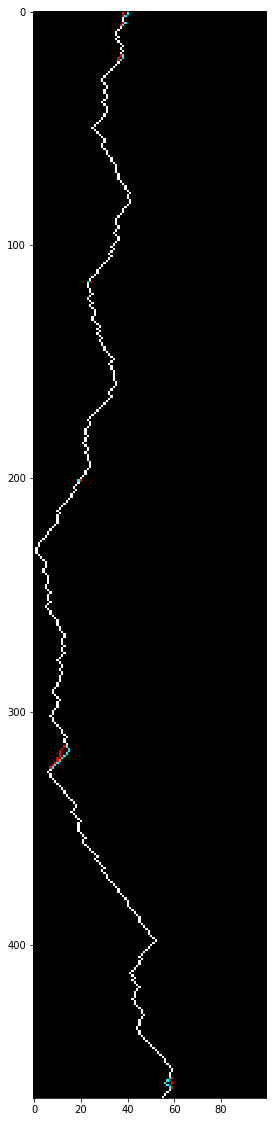

In [108]:
plt.figure(figsize=(10, 20))
plt.imshow(X_[:, :100])

In [73]:
def get_seam_mask(seam, shape):
    mask = np.zeros(shape)
    rows = list(range(len(seam)))
    mask[rows, seam] = 1
    return mask

In [59]:
from pickle import load

In [60]:
gt = None
with open('03_gt/seams', 'rb') as fgt:
    for i in range(1):
        gt = load(fgt)

In [40]:
im, mask, seam_mask = seam_carve(image, mode='horizontal')

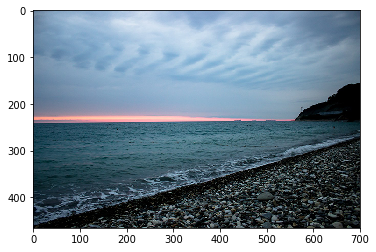

In [45]:
plt.imshow(im)

In [62]:
gt

((0, 40),
 (1, 40),
 (2, 39),
 (3, 38),
 (4, 38),
 (5, 39),
 (6, 38),
 (7, 37),
 (8, 36),
 (9, 35),
 (10, 35),
 (11, 36),
 (12, 35),
 (13, 36),
 (14, 37),
 (15, 38),
 (16, 37),
 (17, 38),
 (18, 37),
 (19, 38),
 (20, 38),
 (21, 37),
 (22, 36),
 (23, 35),
 (24, 34),
 (25, 33),
 (26, 32),
 (27, 31),
 (28, 30),
 (29, 29),
 (30, 29),
 (31, 30),
 (32, 31),
 (33, 31),
 (34, 30),
 (35, 30),
 (36, 31),
 (37, 31),
 (38, 30),
 (39, 29),
 (40, 30),
 (41, 31),
 (42, 31),
 (43, 31),
 (44, 30),
 (45, 30),
 (46, 29),
 (47, 28),
 (48, 27),
 (49, 26),
 (50, 25),
 (51, 26),
 (52, 27),
 (53, 28),
 (54, 29),
 (55, 30),
 (56, 30),
 (57, 29),
 (58, 29),
 (59, 30),
 (60, 31),
 (61, 31),
 (62, 32),
 (63, 33),
 (64, 33),
 (65, 34),
 (66, 35),
 (67, 35),
 (68, 35),
 (69, 35),
 (70, 36),
 (71, 36),
 (72, 36),
 (73, 37),
 (74, 38),
 (75, 39),
 (76, 39),
 (77, 40),
 (78, 41),
 (79, 40),
 (80, 40),
 (81, 41),
 (82, 41),
 (83, 40),
 (84, 39),
 (85, 38),
 (86, 38),
 (87, 37),
 (88, 36),
 (89, 35),
 (90, 35),
 (91, 35)

In [64]:
xs = [i[1] for i in gt]